# Pattern Recognition, Homework 2

* **Author** [Haonan Chen](https://chaonan99.github.io/about/)
* **Class** 32
* **Student No.** 2013011449
* **Date** 2016/10/25
* **Language**
[![logo](https://raw.githubusercontent.com/docker-library/docs/520519ad7db3ea9fd5d3590e836c839a0ffd6f19/julia/logo.png)](http://julialang.org/)
* [Source code](https://github.com/chaonan99/PR_hw/blob/master/h2/src/h2.ipynb) on GitHub.

## Result highlight
* Error rate

|           Sampling           | Features |    Bayes   |     FLD    | Linear SVM |      MLP(hidden_nodes=12)     |
|:----------------------------:|:--------:|:----------:|:----------:|:----------:|:-----------------------------:|
| 10+10 (different every time) |    10    | 12.538226% | 26.299694% | 24.464832% | 72.47706422018348%(epoch=100) |
|  10+10(different every time) |     2    | 22.324159% | 15.596330% | 17.125382% | 82.87461773700305%(epoch=100) |
|            469+485           |    10    | 16.819572% | 10.091743% | 11.926606% | 11.62079510703364%(epoch=500) |
|            469+485           |     2    | 14.067278% | 11.620795% | 12.232416% | 7.339449541284404%(epoch=500) |

## Read training and testing data

Using `Pkg.add(package)` to install packages. Packages unregistered on METADATA should should be installed using `Pkg.clone("...")`. Refer to related section in this demo for more information.

In [1]:
using DataFrames
using Distributions
using Distances
using MultivariateStats
using LIBSVM  # unregistered: refer to SVM section to learn how to install
using ANN  # unregistered: refer to MLP section to learn how to install

In [2]:
df_train = readtable("dataset3.txt", separator = '\t')
df_test = readtable("dataset4.txt", separator = '\t')
names!(df_train, cat(1, [Symbol("F$i") for i in 1:10],[Symbol("Sex")]))  # assign a name to each column
names!(df_test,  cat(1, [Symbol("F$i") for i in 1:10],[Symbol("Sex")]))
df_test[df_test[:,:Sex].=="f",:Sex]="F"
by(df_train, :Sex) do df
  DataFrame(
    number = length(df[:Sex]),
  )
end

,Sex,number
1,F,468
2,M,485


In [3]:
by(df_test, :Sex) do df
  DataFrame(
    number = length(df[:Sex]),
  )
end

,Sex,number
1,F,77
2,M,250


In [4]:
df_train_two_F = df_train[df_train[:,:Sex].=="F",[:F3,:F5]]
df_train_two_M = df_train[df_train[:,:Sex].=="M",[:F3,:F5]]
println("Randomly picked samples with two features for female")
df_train_two_F_s = df_train_two_F[sample(1:size(df_train_two_F, 1), 10, replace = false), :]

Randomly picked samples with two features for female


,F3,F5
1,62.0,166.0
2,45.0,160.0
3,55.0,155.0
4,50.0,157.0
5,52.0,155.0
6,43.0,156.0
7,49.0,165.0
8,43.0,160.0
9,55.0,170.0
10,55.0,160.0


In [5]:
println("Randomly picked samples with two features for male")
df_train_two_M_s = df_train_two_M[sample(1:size(df_train_two_M, 1), 10, replace = false), :]

Randomly picked samples with two features for male


,F3,F5
1,74.0,183.0
2,62.0,170.0
3,88.0,175.0
4,75.0,182.0
5,64.0,171.0
6,67.0,170.0
7,61.0,170.0
8,82.0,188.0
9,68.0,186.0
10,64.0,173.0


In [6]:
df_train_ten_F = df_train[df_train[:,:Sex].=="F", 1:10]
df_train_ten_M = df_train[df_train[:,:Sex].=="M", 1:10]
println("Randomly picked samples with ten features for female")
df_train_ten_F_s = df_train_ten_F[sample(1:size(df_train_ten_F, 1), 10, replace = false), :]

Randomly picked samples with ten features for female


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
1,240.25,19.36,44.0,18.31,155.0,182.0,65.0,183.51,180.05,182.43
2,265.69,25.0,50.0,18.82,163.0,167.0,65.0,170.31,174.64,159.06
3,265.69,22.09,47.0,17.69,163.0,173.0,50.0,173.98,175.44,192.21
4,259.21,24.01,49.0,18.9,161.0,173.0,58.0,177.31,170.52,185.48
5,282.24,22.09,47.0,16.65,168.0,157.0,53.0,155.25,173.57,156.89
6,272.25,25.0,50.0,18.37,165.0,159.0,53.0,174.78,174.66,178.03
7,265.69,24.01,49.0,18.44,163.0,158.0,58.0,157.07,174.08,204.78
8,282.24,38.44,62.0,21.97,168.0,185.0,51.0,151.99,170.88,179.05
9,262.44,28.09,53.0,20.2,162.0,165.0,64.0,177.55,167.83,185.87
10,262.44,22.09,47.0,17.91,162.0,178.0,65.0,169.32,178.01,184.78


In [7]:
println("Randomly picked samples with ten features for male")
df_train_ten_M_s = df_train_ten_M[sample(1:size(df_train_two_M, 1), 10, replace = false), :]

Randomly picked samples with ten features for male


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
1,289.0,38.44,62.0,21.45,170.0,165.0,70.0,164.42,173.44,155.76
2,299.29,36.0,60.0,20.05,173.0,175.0,48.0,185.87,172.96,194.91
3,316.84,47.61,69.0,21.78,178.0,167.0,66.0,177.3,170.25,166.79
4,306.25,44.89,67.0,21.88,175.0,160.0,54.0,166.73,162.86,191.43
5,299.29,42.25,65.0,21.72,173.0,159.0,53.0,179.15,166.04,168.01
6,306.25,39.69,63.0,20.57,175.0,155.0,52.0,183.47,167.58,186.53
7,334.89,57.76,76.0,22.69,183.0,163.0,68.0,160.03,172.09,177.43
8,306.25,56.25,75.0,24.49,175.0,164.0,49.0,163.38,162.67,181.8
9,353.44,67.24,82.0,23.2,188.0,156.0,63.0,170.81,166.21,171.18
10,295.84,44.89,67.0,22.65,172.0,166.0,45.0,166.1,169.57,158.1


* Relation of features
![relation](../doc/resource/feature_relation.png)

## Sex Classification with Bayes Classifier

Follow this procedure:

* Fit Normal Distribution in each class in the training data to get parameters $\mu_i$ and $\Sigma_i$.
* Decision boundary can be determined by
$$
    -\frac12[(x-\mu_i)^\mathbf{T}\Sigma_i^{-1}(x-\mu_i)-(x-\mu_j)^\mathbf{T}\Sigma_j^{-1}(x-\mu_j)]-\frac12\ln \frac{|\Sigma_i|}{|\Sigma_j|}+\ln\frac{P(\omega_i)}{P(\omega_j)}=0
$$
* Then we can make prediction on test set.

Note that we are assuming the priori probability $P(\omega_i)=P(\omega_j)=0.5$, so the last item in the formular above can be ignored.

### Using all samples

In [8]:
# Distribution for female (female first)
norm_two_F = fit(MvNormal, Array(df_train_two_F)')

FullNormal(
dim: 2
μ: [51.7457,163.632]
Σ: [39.2591 16.5807; 16.5807 30.053]
)


In [9]:
# Distribution for male
norm_two_M = fit(MvNormal, Array(df_train_two_M)')

FullNormal(
dim: 2
μ: [68.0334,176.41]
Σ: [85.2565 23.3637; 23.3637 32.5048]
)


In [10]:
maha_two_M = pairwise(SqMahalanobis(norm_two_M.Σ.mat), Array(df_test[:,[:F3, :F5]])', norm_two_M.μ'')
maha_two_F = pairwise(SqMahalanobis(norm_two_F.Σ.mat), Array(df_test[:,[:F3, :F5]])', norm_two_F.μ'')
predict_two = (maha_two_M - maha_two_F + log(det(norm_two_M.Σ.mat)/det(norm_two_F.Σ.mat))) .< 0  # true denotes "M"
error_two = sum(Array(df_test[:, :Sex] .== "M").!=predict_two)/length(predict_two)  # error rate
@printf "Error rate on test set for using all training samples (two features): %.6f%%\n" error_two*100

Error rate on test set for using all training samples (two features): 14.067278%


In [11]:
norm_ten_F = fit(MvNormal, Array(df_train_ten_F)')  # Distribution for female
norm_ten_M = fit(MvNormal, Array(df_train_ten_M)')  # Distribution for male
maha_ten_M = pairwise(SqMahalanobis(norm_ten_M.Σ.mat), Array(df_test[:,1:10])', norm_ten_M.μ'')
maha_ten_F = pairwise(SqMahalanobis(norm_ten_F.Σ.mat), Array(df_test[:,1:10])', norm_ten_F.μ'')
predict_ten = (maha_ten_M - maha_ten_F + log(det(norm_ten_M.Σ.mat)/det(norm_ten_F.Σ.mat))) .< 0  # true denotes "M"
error_ten = sum(Array(df_test[:, :Sex] .== "M").!=predict_ten)/length(predict_ten)  # error rate
@printf "Error rate on test set for using all training samples (ten features): %.6f%%\n" error_ten*100

Error rate on test set for using all training samples (ten features): 16.819572%


### Randomly pick 10 samples

In [12]:
norm_two_F_s = fit(MvNormal, Array(df_train_two_F_s)')  # Distribution for female
norm_two_M_s = fit(MvNormal, Array(df_train_two_M_s)')  # Distribution for male
maha_two_M_s = pairwise(SqMahalanobis(norm_two_M_s.Σ.mat), Array(df_test[:,[:F3, :F5]])', norm_two_M_s.μ'')
maha_two_F_s = pairwise(SqMahalanobis(norm_two_F_s.Σ.mat), Array(df_test[:,[:F3, :F5]])', norm_two_F_s.μ'')
predict_two_s = (maha_two_M_s - maha_two_F_s + log(det(norm_two_M_s.Σ.mat)/det(norm_two_F_s.Σ.mat))) .< 0  # true denotes "M"
error_two_s = sum(Array(df_test[:, :Sex] .== "M").!=predict_two_s)/length(predict_two_s)
@printf "Error rate on test set for randomly picking 20 training samples (two features): %.6f%%\n" error_two_s*100

Error rate on test set for randomly picking 20 training samples (two features): 17.737003%


In [13]:
μ_F = mean(Array(df_train_ten_F_s), 1)
Σ_F = cov(Array(df_train_ten_F_s),1 , false)
μ_M = mean(Array(df_train_ten_M_s), 1)
Σ_M = cov(Array(df_train_ten_M_s),1 , false)
maha_ten_M_s = pairwise(SqMahalanobis(Σ_M), Array(df_test[:,1:10])', μ_M')
maha_ten_F_s = pairwise(SqMahalanobis(Σ_F), Array(df_test[:,1:10])', μ_F')
predict_ten_s = (maha_ten_M_s - maha_ten_F_s + log(abs(det(Σ_M)/det(Σ_F)))) .< 0  # true denotes "M"
error_ten_s = sum(Array(df_test[:, :Sex] .== "M").!=predict_ten_s)/length(predict_ten_s)  # error rate
@printf "Error rate on test set for randomly picking 20 training samples (ten features): %.6f%%\n" error_ten_s*100

Error rate on test set for randomly picking 20 training samples (ten features): 19.877676%


## Sex Classification with LDA

For LDA, the demo use [MultivariateStats](https://github.com/JuliaStats/MultivariateStats.jl). See the document for more details.

A linear discriminant functional can be written as:
$$
f(\mathbf{x}) = \mathbf{w}^T \mathbf{x} + b
$$
Suppose the samples in the positive and negative classes respectively with means:  $\boldsymbol{\mu}_p$ and $\boldsymbol{\mu}_n$ , and within-class scatter matrixes  $\mathbf{S}_p$ and  $\mathbf{S}_n$. Then based on *Fisher's Linear Discriminant Criteria*, the optimal projection direction can be expressed as:
$$
\mathbf{w} = \alpha \cdot (\mathbf{S}_p + \mathbf{S}_n)^{-1} (\boldsymbol{\mu}_p - \boldsymbol{\mu}_n)
$$
Here $\alpha$ is an arbitrary non-negative coefficient.
The threshold $b$ can be obtained by:
$$
b = -\frac12(\boldsymbol{\mu}_p + \boldsymbol{\mu}_n)(\mathbf{S}_p + \mathbf{S}_n)^{-1} (\boldsymbol{\mu}_p - \boldsymbol{\mu}_n)-\ln\frac{P(\omega_p)}{P(\omega_n)}
$$
Again we assume $P(\omega_p)=P(\omega_n)=0.5$, then the last item can be ignored.

### Using all samples

In [14]:
lda_model_two = fit(LinearDiscriminant, Array(df_train_two_M)', Array(df_train_two_F)')

MultivariateStats.LinearDiscriminant{Float64}([0.0497863,0.0930593],-18.803757960270772)

In [15]:
error_lda_two = mean(Array(df_test[:, :Sex] .== "M") .!= MultivariateStats.predict(lda_model_two, Matrix(df_test[:, [:F3, :F5]])'))
@printf "Error rate on test set for using all training samples (two features): %.6f%%\n" error_lda_two*100

Error rate on test set for using all training samples (two features): 11.620795%


In [16]:
lda_model_ten = fit(LinearDiscriminant, Array(df_train_ten_M)', Array(df_train_ten_F)')
error_lda_ten = mean(Array(df_test[:, :Sex] .== "M") .!= MultivariateStats.predict(lda_model_ten, Matrix(df_test[:, 1:10])'))
@printf "Error rate on test set for using all training samples (ten features): %.6f%%\n" error_lda_ten*100

Error rate on test set for using all training samples (ten features): 10.091743%


### Randomly pick 10 samples

In [17]:
lda_model_two_s = fit(LinearDiscriminant, Array(df_train_two_M_s)', Array(df_train_two_F_s)')
error_lda_two_s = mean(Array(df_test[:, :Sex] .== "M") .!= MultivariateStats.predict(lda_model_two_s, Matrix(df_test[:, [:F3, :F5]])'))
@printf "Error rate on test set for randomly picking 20 training samples (two features): %.6f%%\n" error_lda_two_s*100

Error rate on test set for randomly picking 20 training samples (two features): 11.314985%


In [18]:
lda_model_ten_s = fit(LinearDiscriminant, Array(df_train_ten_M_s)', Array(df_train_ten_F_s)')
error_lda_ten_s = mean(Array(df_test[:, :Sex] .== "M") .!= MultivariateStats.predict(lda_model_ten_s, Matrix(df_test[:, 1:10])'))
@printf "Error rate on test set for randomly picking 20 training samples (ten features): %.6f%%\n" error_lda_ten_s*100

Error rate on test set for randomly picking 20 training samples (ten features): 22.324159%


## Sex Classification with Linear SVM

The demo use [LIBSVM](https://github.com/simonster/LIBSVM.jl), a Julia bindings for [LIBSVM](http://www.csie.ntu.edu.tw/~cjlin/libsvm/) developed by Chih-Chung Chang and Chih-Jen Lin.

For Linux user, run
```
Pkg.clone("https://github.com/simonster/LIBSVM.jl.git")
```
For Windows user, a possible solution is:
* Download LIBSVM to Julia package repo by
    ```
    Pkg.clone("https://github.com/simonster/LIBSVM.jl.git")
    ```
* Install [MinGW32](http://www.mingw.org/wiki/HOWTO_Install_the_MinGW_GCC_Compiler_Suite)
* Change [this line](https://github.com/simonster/LIBSVM.jl/blob/master/deps/build.jl#L2) to
    ```
    mingw32-make lib
    ```
* Run `Pkg.build("LIBSVM")`

Related issue: [this](https://github.com/simonster/LIBSVM.jl/issues/18#issuecomment-255679633) and [this](https://github.com/simonster/LIBSVM.jl/issues/9).

In `LIBSVM` binding, the default kernel is `RBF` kernel. Here we provide the result on both `Linear` kernel and `RBF` kernel.

### Using all samples

In [19]:
model_two = svmtrain(Array(df_train[:, :Sex]), Array(df_train[:, [:F3,:F5]])', kernel_type = LIBSVM.Linear)
(predicted_labels, decision_values) = svmpredict(model_two, Array(df_test[:, [:F3,:F5]])');
@printf "Error on test set with linear kernel (two features): %.6f%%\n" mean((predicted_labels .!= df_test[:,:Sex]))*100
model_two = svmtrain(Array(df_train[:, :Sex]), Array(df_train[:, [:F3, :F5]])', kernel_type = LIBSVM.RBF)
(predicted_labels, decision_values) = svmpredict(model_two, Array(df_test[:, [:F3, :F5]])');
@printf "Error on test set with RBF kernel (two features): %.6f%%\n" mean((predicted_labels .!= df_test[:,:Sex]))*100

Error on test set with linear kernel (two features): 12.232416%
Error on test set with RBF kernel (two features): 11.926606%


In [20]:
model_two = svmtrain(Array(df_train[:, :Sex]), Array(df_train[:, 1:10])', kernel_type = LIBSVM.Linear)
(predicted_labels, decision_values) = svmpredict(model_two, Array(df_test[:, 1:10])');
@printf "Error on test set with linear kernel (ten features): %.6f%%\n" mean((predicted_labels .!= df_test[:,:Sex]))*100
model_ten = svmtrain(Array(df_train[:, :Sex]), Array(df_train[:, 1:10])', kernel_type = LIBSVM.RBF)
(predicted_labels, decision_values) = svmpredict(model_ten, Array(df_test[:, 1:10])');
@printf "Error on test set with RBF kernel (ten features): %.6f%%\n" mean((predicted_labels .!= df_test[:,:Sex]))*100

Error on test set with linear kernel (ten features): 11.926606%
Error on test set with RBF kernel (ten features): 23.241590%


### Randomly pick 10 samples

In [21]:
arr_train_two_s = [Array(df_train_two_M_s); Array(df_train_two_F_s)]
arr_train_label_s = [fill("M", 10);fill("F", 10)]
model_two = svmtrain(arr_train_label_s, arr_train_two_s', kernel_type = LIBSVM.Linear)
(predicted_labels, decision_values) = svmpredict(model_two, Array(df_test[:, [:F3, :F5]])');
@printf "Error on test set with linear kernel (two features): %.6f%%\n" mean((predicted_labels .!= df_test[:,:Sex]))*100
model_two = svmtrain(arr_train_label_s, arr_train_two_s', kernel_type = LIBSVM.RBF)
(predicted_labels, decision_values) = svmpredict(model_two, Array(df_test[:, [:F3, :F5]])');
@printf "Error on test set with RBF kernel (two features): %.6f%%\n" mean((predicted_labels .!= df_test[:,:Sex]))*100

Error on test set with linear kernel (two features): 11.314985%
Error on test set with RBF kernel (two features): 65.137615%


In [22]:
arr_train_ten_s = [Array(df_train_ten_M_s); Array(df_train_ten_F_s)]
model_ten = svmtrain(arr_train_label_s, arr_train_ten_s', kernel_type = LIBSVM.Linear)
(predicted_labels, decision_values) = svmpredict(model_ten, Array(df_test[:, 1:10])');
@printf "Error on test set with linear kernel (ten features): %.6f%%\n" mean((predicted_labels .!= df_test[:,:Sex]))*100
model_ten = svmtrain(arr_train_label_s, arr_train_ten_s', kernel_type = LIBSVM.RBF)
(predicted_labels, decision_values) = svmpredict(model_ten, Array(df_test[:, 1:10])');
@printf "Error on test set with RBF kernel (ten features): %.6f%%\n" mean((predicted_labels .!= df_test[:,:Sex]))*100

Error on test set with linear kernel (ten features): 9.480122%
Error on test set with RBF kernel (ten features): 22.018349%


## Sex Classification with MLP

The program use unregistered [ANN](https://github.com/ericchiang/ANN.jl) package to build MLP. Run
```
Pkg.clone("https://github.com/ericchiang/ANN.jl.git")
```
to install.

### Function definations

* Map Label to Int64 in order to feed into neural network

In [23]:
function mapLabelToInt(org::Array{String, 1})
    dst = zeros(Int64, size(org))
    classes = unique(org)
    for (index, value) in enumerate(classes)
        dst[org.==value] = index
    end
    dst
end

mapLabelToInt (generic function with 1 method)

* Structure and method to do data pre-pocessing (normalization). [Reference](http://blog.yhat.com/posts/julia-neural-networks.html).

In [ ]:
type StandardScalar
    mean::Vector{Float64}
    std::Vector{Float64}
end

# Helper function to initialize an empty scalar
function StandardScalar()
    StandardScalar(Array(Float64,0),Array(Float64,0))
end

# Compute mean and standard deviation of each column
function fit_std_scalar!(std_scalar::StandardScalar,X::Matrix{Float64})
    n_rows, n_cols = size(X)
    std_scalar.std = zeros(n_cols)
    std_scalar.mean = zeros(n_cols)
    # for loops are fast again!
    for i = 1:n_cols
        std_scalar.mean[i] = mean(X[:,i])
        std_scalar.std[i] = std(X[:,i])
    end
end

function transform(std_scalar::StandardScalar,X::Matrix{Float64})
    (X .- std_scalar.mean') ./ std_scalar.std' # broadcasting fu
end

# fit and transform in one function
function fit_transform!(std_scalar::StandardScalar,X::Matrix{Float64})
    fit_std_scalar!(std_scalar,X)
    transform(std_scalar,X)
end

* Evaluation routing

In [25]:
function evaluate_routing(ann::ArtificialNeuralNetwork,test_data::Matrix,test_label::Vector{String})
    proba = ANN.predict(ann, test_data)
    pred = Array(Int64, size(test_data, 1))
    for i in 1:size(X_test, 1)
        pred[i] = ann.classes[indmax(proba[i,:])]
    end
    error_rate = mean(pred .!= mapLabelToInt(Array(test_label)))
    pred, error_rate
end

evaluate_routing (generic function with 1 method)

### Using all samples

In [26]:
ann_two = ArtificialNeuralNetwork(12)  # build the network, using 12 hidden nodes.
std_scalar = StandardScalar()  # these consequtive 3 lines normalizing training and testing data
X_train_ = fit_transform!(std_scalar, Matrix(df_train[[:F3,:F5]]))
X_test = transform(std_scalar, Matrix(df_test[[:F3,:F5]]))
ANN.fit!(ann_two, X_train, mapLabelToInt(Array(df_train[:,:Sex])), epochs=500, alpha=0.1, lambda=1e-5)  # training

LoadError: LoadError: UndefVarError: fit_transform! not defined
while loading In[26], in expression starting on line 3

In [27]:
_, error_rate = evaluate_routing(ann_two, X_test, Array(df_test[:Sex]))
println("Error rate (two features): ",error_rate*100,"%")

LoadError: LoadError: UndefVarError: X_test not defined
while loading In[27], in expression starting on line 1

In [28]:
ann_ten = ArtificialNeuralNetwork(12)  # build the network, using 12 hidden nodes.
std_scalar = StandardScalar()  # these consequtive 3 lines normalizing training and testing data
X_train = fit_transform!(std_scalar, Matrix(df_train[1:10]))
X_test = transform(std_scalar, Matrix(df_test[1:10]))
ANN.fit!(ann_ten, X_train, mapLabelToInt(Array(df_train[:,:Sex])), epochs=500, alpha=0.1, lambda=1e-5)  # training
_, error_rate = evaluate_routing(ann_ten, X_test, Array(df_test[:Sex]))
println("Error rate (ten features): ",error_rate*100,"%")

LoadError: LoadError: UndefVarError: fit_transform! not defined
while loading In[28], in expression starting on line 3

### Randomly pick 10 samples

In [29]:
ann_two_s = ArtificialNeuralNetwork(12)  # build the network, using 12 hidden nodes.
std_scalar = StandardScalar()  # these consequtive 3 lines normalizing training and testing data
X_train = fit_transform!(std_scalar, arr_train_two_s)
X_test = transform(std_scalar, Matrix(df_test[[:F3,:F5]]))
ANN.fit!(ann_two_s, X_train, mapLabelToInt(arr_train_label_s), epochs=100, alpha=0.1, lambda=1e-5)  # training
pred_res, error_rate = evaluate_routing(ann_two_s, X_test, Array(df_test[:Sex]))
println("Error rate: ",error_rate*100,"%")
# _,count = hist(pred_res)
# println(count)

LoadError: LoadError: UndefVarError: fit_transform! not defined
while loading In[29], in expression starting on line 3

In [30]:
ann_ten_s = ArtificialNeuralNetwork(12)  # build the network, using 12 hidden nodes.
std_scalar = StandardScalar()  # these consequtive 3 lines normalizing training and testing data
X_train = fit_transform!(std_scalar, arr_train_ten_s)
X_test = transform(std_scalar, Matrix(df_test[1:10]))
ANN.fit!(ann_ten_s, X_train, mapLabelToInt(arr_train_label_s), epochs=100, alpha=0.1, lambda=1e-5)  # training
pred_res, error_rate = evaluate_routing(ann_ten_s, X_test, Array(df_test[:Sex]))
println("Error rate: ",error_rate*100,"%")
# _,count = hist(pred_res)
# println(count)

LoadError: LoadError: UndefVarError: fit_transform! not defined
while loading In[30], in expression starting on line 3

The ANN model predict equal number of male and female samples with limited training samples, thus performs bad on a biased test set.

## Other Experiments

* Train neural network using feature 6-10 using all training samples. Other settings remain the same. The high error rate compared with 2 features (7.33% error rate) shows that feature 6-10 is less discriminative.

In [31]:
ann_five = ArtificialNeuralNetwork(12)  # build the network, using 12 hidden nodes.
std_scalar = StandardScalar()  # these consequtive 3 lines normalizing training and testing data
X_train = fit_transform!(std_scalar, Matrix(df_train[[:F6, :F7, :F8,:F9, :F10]]))
X_test = transform(std_scalar, Matrix(df_test[[:F6, :F7, :F8,:F9, :F10]]))
ANN.fit!(ann_five, X_train, mapLabelToInt(Array(df_train[:,:Sex])), epochs=500, alpha=0.1, lambda=1e-5)  # training
_, error_rate = evaluate_routing(ann_five, X_test, Array(df_test[:Sex]))
println("Error rate (five features 6-10): ",error_rate*100,"%")

LoadError: LoadError: UndefVarError: fit_transform! not defined
while loading In[31], in expression starting on line 3

In [ ]:
# Python Code source: Gaël Varoquaux
#                     Andreas Müller
# Julia adaptation: Cédric St-Jean
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

using ScikitLearn
using PyCall
using PyPlot
using ScikitLearn.CrossValidation: train_test_split
using DecisionTree
#using ScikitLearn.Models: DecisionTreeClassifier, RandomForestClassifier, AdaBoostStumpClassifier
@pyimport matplotlib.colors as mplc
@sk_import preprocessing: StandardScaler
@sk_import datasets: (make_moons, make_circles, make_classification)
@sk_import neighbors: KNeighborsClassifier
@sk_import svm: SVC
@sk_import naive_bayes: GaussianNB
@sk_import discriminant_analysis: (LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis)
using ScikitLearn.Utils: meshgrid

In [40]:
h = .02  # step size in the mesh

names = ["Bayes", "LDA", "Linear SVM", "RBF SVM"]
classifiers = [
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
srand(42)
X += 2 * rand(size(X)...)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ];

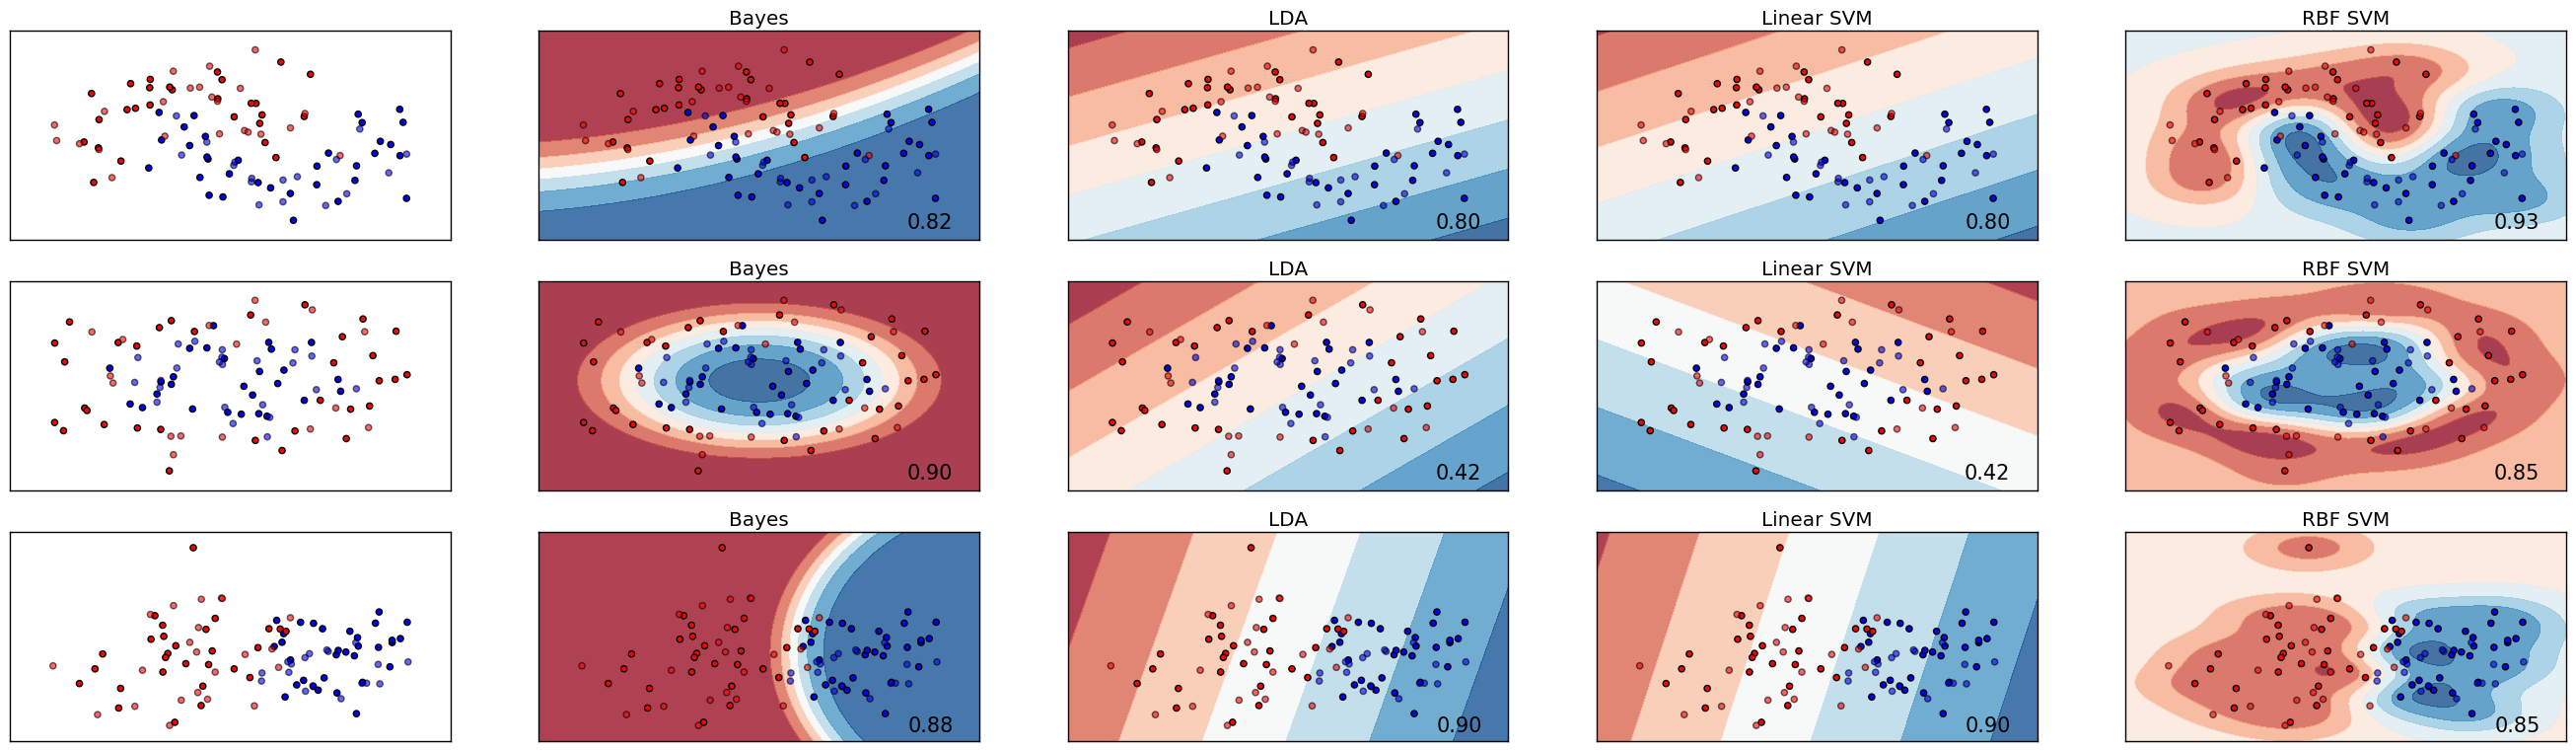

In [41]:
fig = figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets
    # preprocess dataset, split into training and test part
    X, y = ds
    X = fit_transform!(StandardScaler(), X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = minimum(X[:, 1]) - .5, maximum(X[:, 1]) + .5
    y_min, y_max = minimum(X[:, 2]) - .5, maximum(X[:, 2]) + .5
    xx, yy = meshgrid(x_min:h:x_max, y_min:h:y_max)

    # just plot the dataset first
    cm = PyPlot.cm[:RdBu]
    cm_bright = mplc.ListedColormap(["#FF0000", "#0000FF"])
    ax = subplot(length(datasets), length(classifiers) + 1, i)
    # Plot the training points
    ax[:scatter](X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright)
    # and testing points
    ax[:scatter](X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright, alpha=0.6)

    ax[:set_xlim](minimum(xx), maximum(xx))
    ax[:set_ylim](minimum(yy), maximum(yy))
    ax[:set_xticks](())
    ax[:set_yticks](())
    i += 1

    # iterate over classifiers
    for (name, clf) in zip(names, classifiers)
        ax = subplot(length(datasets), length(classifiers) + 1, i)
        ScikitLearn.fit!(clf, X_train, y_train)
        scor = score(clf, X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        try 
            # Not implemented for some
            Z = decision_function(clf, hcat(xx[:], yy[:]))
        catch
            Z = predict_proba(clf, hcat(xx[:], yy[:]))[:, 2]
        end

        # Put the result into a color plot
        Z = reshape(Z, size(xx)...)
        ax[:contourf](xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax[:scatter](X_train[:, 1], X_train[:, 2], c=y_train, cmap=cm_bright)
        # and testing points
        ax[:scatter](X_test[:, 1], X_test[:, 2], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax[:set_xlim](minimum(xx), maximum(xx))
        ax[:set_ylim](minimum(yy), maximum(yy))
        ax[:set_xticks](())
        ax[:set_yticks](())
        ax[:set_title](name)

        ax[:text](maximum(xx) - .3, minimum(yy) + .3, @sprintf("%.2f", scor),
                size=15, horizontalalignment="right")
        i += 1
    end
end
fig[:subplots_adjust](left=.02, right=.98)